In [34]:
import cv2
import json
import urllib
import numpy as np
from pathlib import Path
import PIL.Image as Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

PATH_ANOT = 'data/ann/'
PATH_IMG = 'data/img/'

plt.rcParams["figure.figsize"] = (10,10)

In [6]:
# check json
f = 'data/ann/11752905643_a17ce5b925_c.jpg.json'
with Path(f).open() as json_file:
    data = json.load(json_file) 
data

{'description': '',
 'tags': [],
 'size': {'height': 541, 'width': 800},
 'objects': [{'id': 700799253,
   'classId': 2908317,
   'description': '',
   'geometryType': 'rectangle',
   'labelerLogin': 'beifa',
   'createdAt': '2021-04-27T17:22:24.515Z',
   'updatedAt': '2021-04-27T17:23:01.398Z',
   'tags': [],
   'classTitle': 'parrot',
   'points': {'exterior': [[210, 133], [436, 416]], 'interior': []}}]}

In [119]:
tmp = []
for f, img in zip(sorted(Path(PATH_ANOT).glob('*.*')), sorted(Path(PATH_IMG).glob('*.*'))):
    with Path(f).open() as json_file:
        # loads json
        data = json.load(json_file)
        # add array img to dict save to use after
        data['image'] = cv2.cvtColor( cv2.imread(str(img)), cv2.COLOR_BGR2RGB) 
        tmp.append(data)

In [111]:
tmp[0]

{'description': '',
 'tags': [],
 'size': {'height': 541, 'width': 800},
 'objects': [{'id': 700799253,
   'classId': 2908317,
   'description': '',
   'geometryType': 'rectangle',
   'labelerLogin': 'beifa',
   'createdAt': '2021-04-27T17:22:24.515Z',
   'updatedAt': '2021-04-27T17:23:01.398Z',
   'tags': [],
   'classTitle': 'parrot',
   'points': {'exterior': [[210, 133], [436, 416]], 'interior': []}}],
 'image': array([[[154, 216, 255],
         [154, 216, 255],
         [154, 216, 255],
         ...,
         [140, 202, 251],
         [145, 207, 254],
         [140, 204, 248]],
 
        [[154, 216, 255],
         [154, 216, 255],
         [154, 216, 255],
         ...,
         [138, 201, 254],
         [144, 210, 255],
         [139, 207, 254]],
 
        [[154, 216, 255],
         [154, 216, 255],
         [154, 216, 255],
         ...,
         [140, 203, 255],
         [145, 211, 255],
         [135, 202, 254]],
 
        ...,
 
        [[151, 214, 255],
         [152, 215, 2

In [118]:
import copy

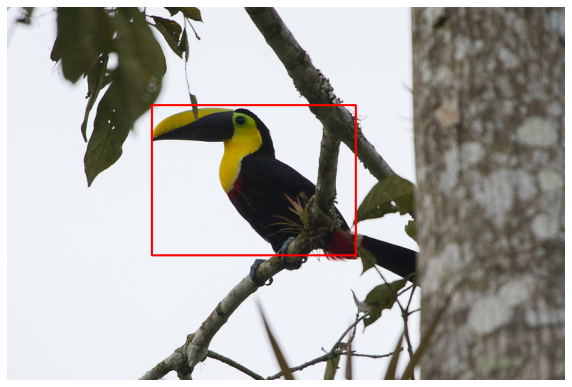

In [120]:
example_img = copy.deepcopy(tmp[1]['image'])

p1, p2 = tmp[1]['objects'][0]['points']['exterior']
x1, y1 = p1
x2, y2 = p2

exp_box = cv2.rectangle(
    example_img,(int(x1), int(y1)),(int(x2), int(y2)),
    color = (255, 0, 0),
    thickness = 2
    )

plt.imshow(exp_box)
plt.axis('off');

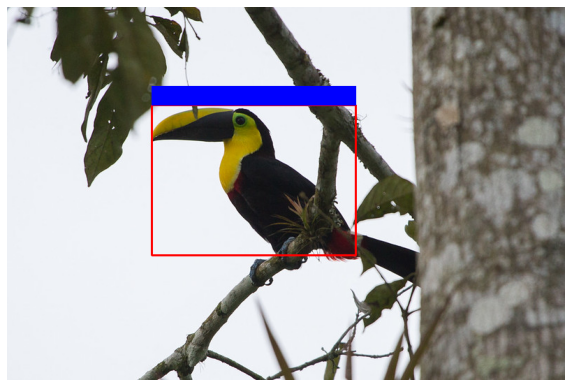

In [121]:
(l_w, l_h), _ = cv2.getTextSize(tmp[1]['objects'][0]['classTitle'],
                                fontFace = cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,
                                fontScale = 1.25,
                                thickness = 1
                                ) # ((161, 43), 18)


plt.imshow(cv2.rectangle(exp_box,
              (int(x1), int(y1)),
              (int(x2), int(y1-l_h)),
              color = (0, 0, 255),
              thickness=cv2.FILLED
              ))
plt.axis('off');

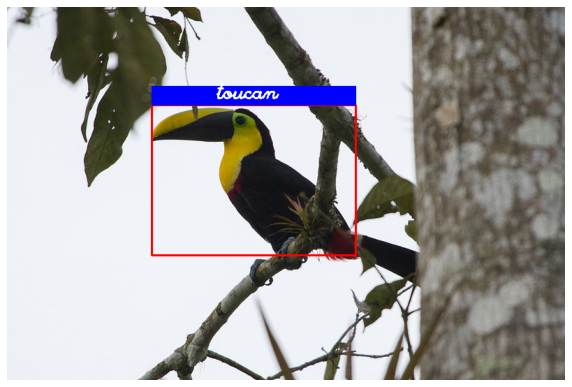

In [122]:
plt.imshow(
    cv2.putText(
        exp_box,
        tmp[1]['objects'][0]['classTitle'],
        org=(

            int(
                ((x1+x2)//2)-(l_w//2)
                ), 
            int(y1-10)
            ),
        fontFace = cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,
        fontScale = 1.05,
        color = (255, 255, 255),
        thickness = 2
        )
    )
plt.axis('off');

In [123]:
tr, vl = train_test_split(tmp, test_size =.2, random_state=13)
len(tr), len(vl)

(61, 16)

In [124]:
def make_data(list_jsn: list, mark: str)->None:
    """
    list_jsn: list dict
    mark: train or val change name dir
    we make data to yolo format:
    |_data
        |_images
            |-train
            |-val
        |-label
            |-train
            |-val
    
    *317 parrot
    *318 toucan
    """
    # labels id to save
    tmp_ids = {'2908317': 0, '2908318': 1}

    img_path = Path(f'parrot_train/images/{mark}')
    img_path.mkdir(parents=True, exist_ok = True)

    lb_path = Path(f'parrot_train/labels/{mark}')
    lb_path.mkdir(parents=True, exist_ok = True)

    for i in range(len(list_jsn)):
        data = list_jsn[i]
        name_ids = data['objects'][0]['id']
        img = Image.fromarray(data['image'])  
        label_ids = tmp_ids[str(data['objects'][0]['classId'])]
        # rename and save img
        img.save(img_path / f'{name_ids}.jpeg')
        # point in pixels need normolize to yolo format
        box = data['objects'][0]['points']['exterior']
        bbox = np.array(box).ravel()
        h, w = data['size']['height'], data['size']['width']
        p1, p2 = tmp[0]['objects'][0]['points']['exterior']
        x1, y1 = p1
        x2, y2 = p2
        # https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
        b_width = bbox[2,]
        b_height = bbox[3,]
        x_max = bbox[0,] + b_width
        y_max = bbox[1,] + b_height
        x_center= ((x_max + bbox[0,]) / 2)  / w
        y_center = ((y_max + bbox[1,]) / 2)  / h
        w1 = bbox[2,] / w
        h1 = bbox[3,] / h
        # save format Each row is class x_center y_center width height format
        with (lb_path / f'{name_ids}.txt').open(mode = 'w') as lb:
            lb.write(f"{label_ids} {x_center} {y_center} {w1} {h1}\n")

In [125]:
# make data to rain
mark = 'train'
make_data(tr, mark)
mark = 'val'
make_data(vl, mark)

In [26]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 5989, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 5989 (delta 2), reused 2 (delta 0), pack-reused 5979
Receiving objects: 100% (5989/5989), 8.39 MiB | 1.58 MiB/s, done.
Resolving deltas: 100% (4096/4096), done.


In [3]:
%cd yolov5/

/home/pka/kaggle/parrot_toucan/yolov5



     Epoch   gpu_mem       box       obj       cls     total    labels  img_size
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95: 100% 24/24 [00:00<00:00, 25.66it/s]
                 all          48          48       0.933       0.964       0.971       0.765
              parrot          48          20       0.909       0.999       0.983       0.744
              toucan          48          28       0.957       0.929       0.958       0.787
120 epochs completed in 0.256 hours.

In [ ]:
%run train.py --img 640 --batch 9 --epochs 150\
                 --data ../config_yolo/data_config.yaml\
                 --cfg ../config_yolo/yolov5m.yaml\
                 --weights yolov5m.pt\
                 --name ../model_yolo/yolov5m_parrot\
                 --cache


```
Epoch   gpu_mem       box       obj       cls     total    labels  img_size     
149/149      5.8G   0.01731   0.01388  0.008292   0.03948        16       640: 100% 9/9 [00:02<00:00,  4.11it/s]   
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95: 100% 3/3 [00:01<00:00,  2.28it/s]
                 all          38          38       0.979           1       0.995       0.909
              parrot          38          16       0.958           1       0.995       0.938
              toucan          38          22           1           1       0.995        0.88
              
150 epochs completed in 0.229 hours.
```

In [18]:
from IPython.display import Image

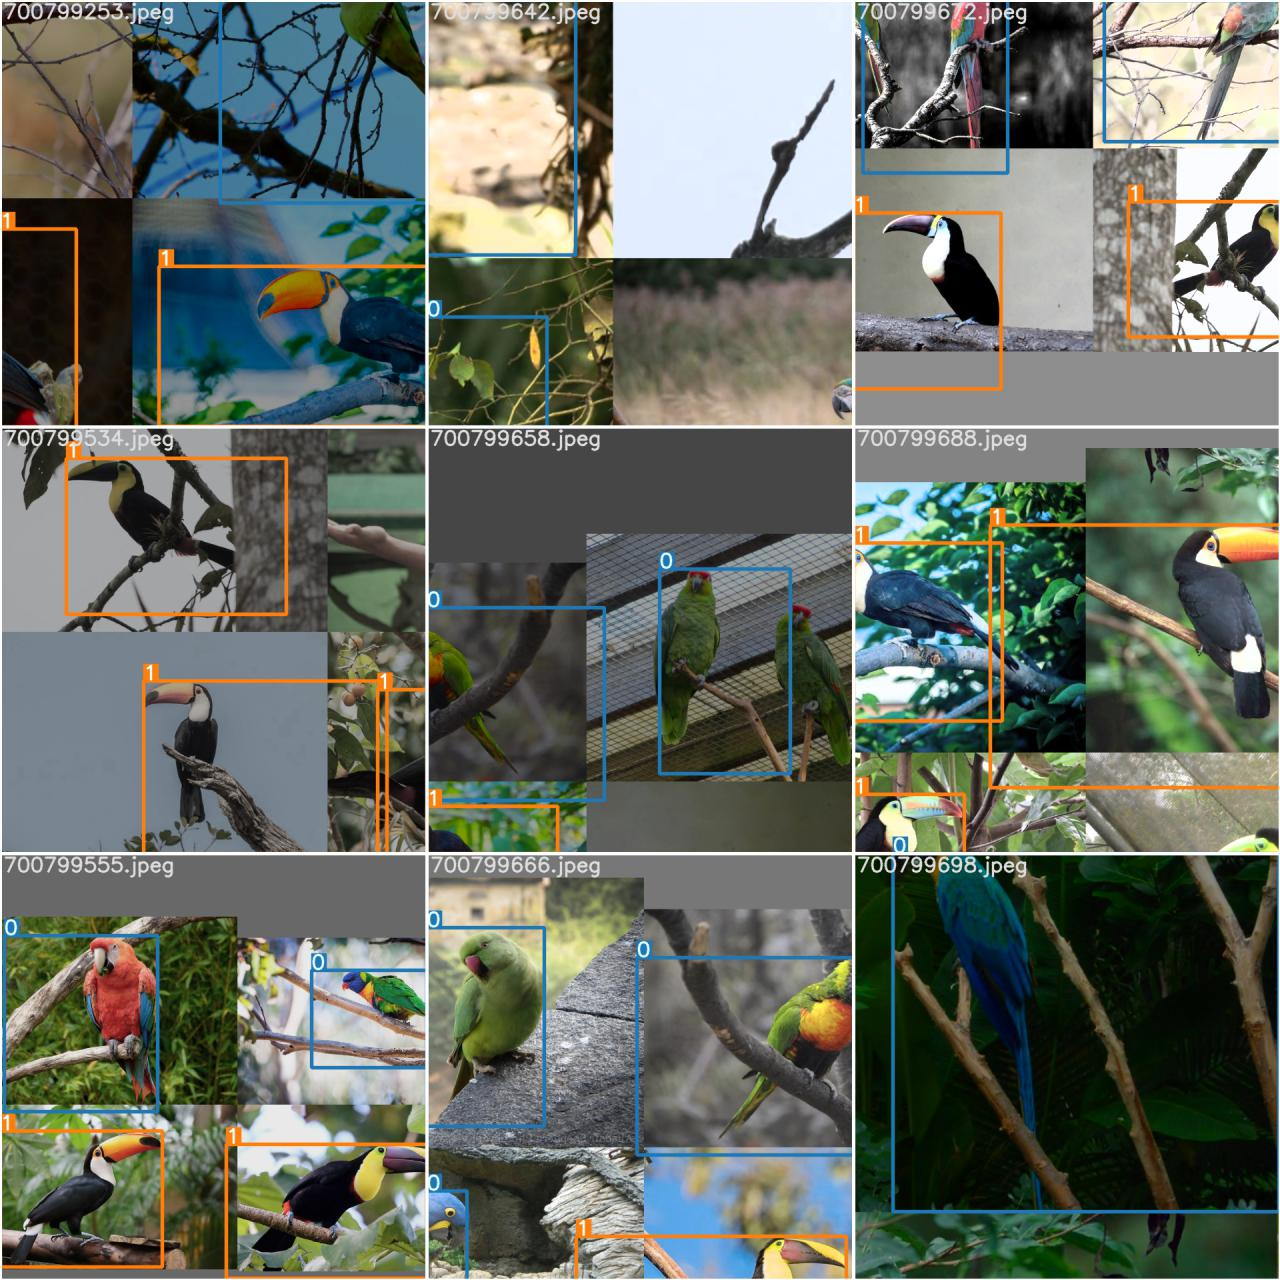

In [19]:
# result train model
Image(filename='model_yolo/yolov5m_parrot8/train_batch0.jpg', width=800) 

In [ ]:
%run yolov5/detect.py --weights model_yolo/yolov5m_parrot8/weights/best.pt\
                      --img 640\
                      --conf 0.4\
                      --source parrot_train/images/val

In [90]:
tmp = []
# after each pred changed exp{num} change
num = len(list(Path('runs/detect/').glob('*')))
for f in Path('runs/detect/').glob(f'exp{num}/*.*'):
    im = cv2.imread(str(f))
    out = cv2.resize(im, (320, 320), interpolation = cv2.INTER_AREA)
    tmp.append(out)    

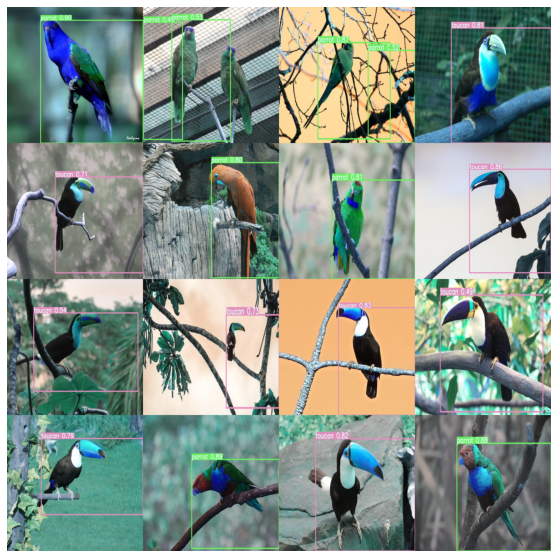

In [91]:
plt.imshow(np.concatenate(np.array(tmp).reshape(4, 320*4,320,3), axis= 1));
plt.axis('off');